# Imports

In [1]:
import re
import nltk
import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from torchtext.data import Field, BucketIterator, TabularDataset
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from preprocessing import *
from dataset import *
from metrics import *
from train import *
from plots import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Hyperparameters of the process

In [3]:
batch_size = 32
max_vocab_size = 25_000
epochs = 5
learning_rate = 0.0075
clip = 10
# glove = 'glove.6B.100d'
glove = 'glove.twitter.27B.100d'

# Preprocessing and preparing the dataset

In [4]:
# EDIT THE PATH OF THE CSV HERE
root_dir = os.path.join('.', 'drive', 'My Drive', 'Colab Notebooks', 'AI2',
                        'Project1', 'dataset')
filename = 'SentimentTweets.csv'
split_dir_name = os.path.join(root_dir, 'split_dataset')

# split the full dataset into 3 files for train-val-test, in the split_dir
filenames = split_dataset(root_dir, filename, split_dir_name, train_size=0.90)
# filenames = ('train_dataset.csv', 'val_dataset.csv', 'test_dataset.csv')

In [5]:
# get the datasets and the Bucket Iterators
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEXT, LABEL, datasets, iterators = parse_datasets(split_dir_name, filenames,
                                                  device, batch_size=batch_size,
                                                  glove=glove,
                                                  max_vocab_size=max_vocab_size)

.vector_cache/glove.twitter.27B.zip: 1.52GB [11:41, 2.17MB/s]                            
100%|█████████▉| 1192456/1193514 [00:50<00:00, 23722.05it/s]

In [6]:
device

device(type='cuda')

In [7]:
# unpack the datasets and the iterators
train_dataset, val_dataset, test_dataset = datasets
train_iterator, val_iterator, test_iterator = iterators

# Model

In [8]:
class RNN(nn.Module):
  """ Recurrent Neural Network Class """

  def __init__(self, TEXT, config):
    """
    :param torchtext.data.Field TEXT:  A Field object representing the text
                                          data of the model.
    :param dict config:                Dictionary containing key-values pairs
                                          that define the architecture of the
                                          model.
    """
    super(RNN, self).__init__()

    cells = {
        'RNN': nn.RNN,
        'GRU': nn.GRU,
        'LSTM': nn.LSTM
    }

    # get the different hyperparameters
    self.cell_type = config['cell_type']
    self.emb_dim = config['emb_dim']
    self.vocab_size = config['vocab_size']
    self.hidden_dim = config['hidden_dim']
    self.num_layers = config['num_layers']
    self.rnn_dropout = config['rnn_dropout']
    self.dropout_rate = config['dropout_rate']
    self.bidirectional = config['bidirectional']
    self.classes = config['classes']

    # create the embedding layer
    glove = TEXT.vocab.vectors
    self.embedding = nn.Embedding(num_embeddings=self.vocab_size,
                                  embedding_dim=self.emb_dim).from_pretrained(glove)

    # make sure that the embeddings will not be updated
    self.embedding.weight.requires_grad = False

    # create a set of RNN layers
    self.rnn = cells[self.cell_type](self.emb_dim, self.hidden_dim,
                                     num_layers=self.num_layers,
                                     dropout=self.rnn_dropout,
                                     bidirectional=self.bidirectional)
    
    # dropout layer
    self.dropout = nn.Dropout(self.dropout_rate)

    # create the fully connected layer
    rnn_output_dim = self.hidden_dim
    if self.bidirectional:
      rnn_output_dim *= 2

    classes = self.classes
    if self.classes == 2:
      classes = 1

    self.fc = nn.Linear(in_features=rnn_output_dim, out_features=classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, X, lengths):
    """
    :param Tensor X:        Input to be fed to the RNN. [maxlen x batch_size]
    :param Tensor lengths:  Actual length of each training example in the batch.
                            [1 x batch_size]
                            
    :return:  The output of the model. [1 x batch_size]
    :rtype:   Tensor
    """

    # take the embeddings each word in the sentence
    embedded = self.embedding(X)

    # unpad the sequence, that is, remove the embeddings of the padding token
    unpadded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.to('cpu'))

    # run through the RNN
    if self.cell_type == 'LSTM':
      rnn_outputs, (last_hidden_state, last_cell_state) = self.rnn(unpadded)
    else:
      rnn_outputs, last_hidden_state = self.rnn(unpadded)

    # get the data of the last hidden state for each layer
    batch_size = X.shape[1]
    num_directions = 2 if self.bidirectional else 1
    data = last_hidden_state.data.view(self.num_layers, num_directions,
                                       batch_size, self.hidden_dim)

    # if bidirectional
    if self.bidirectional:
      # concatenate the last hiddens states (-> and <-) of the topmost layer
      hidden_states_concatenated = torch.cat((data[-1, 0, :, :], data[-1, 1, :, :]), dim=1)
    else:
      # else, just get the last hidden state of the topmost layer
      hidden_states_concatenated = data[-1, 0, :, :]

    # run through the fully connected layer and a sigmoid to get probabilities
    if self.dropout_rate > 0.0:
      hidden_states_concatenated = self.dropout(hidden_states_concatenated)

    output_fc = self.fc(hidden_states_concatenated)
    output = self.sigmoid(output_fc)

    return output

  def unfreeze_embedding(self):
    """
    This method makes the embedding layer trainable.
    """
    self.embedding.weight.requires_grad = True

## Create the model

In [9]:
 config = {
    'cell_type': 'LSTM',
    'emb_dim': 100,
    'vocab_size': len(TEXT.vocab),
    'hidden_dim': 512,
    'num_layers': 2,
    'rnn_dropout': 0.1,
    'dropout_rate': 0.1,
    'bidirectional': True,
    'classes': 2
}

classifier = RNN(TEXT, config)
classifier.to(device)

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): LSTM(100, 512, num_layers=2, dropout=0.1, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Define here the loss function, the optimizer and the scheduler

In [10]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
criterion = nn.BCELoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,
                                                       patience=2, eps=1e-5,
                                                       verbose=True)
# scheduler = None

# Train!

In [11]:
# method found in train.py, should take ~3.5 minutes/epoch on GPU
metrics = train(classifier, train_iterator, val_iterator, epochs,
                optimizer, criterion, scheduler=scheduler, clip=clip,
                unfreeze_on_epoch=0, verbose=True)

100%|█████████▉| 1192456/1193514 [01:10<00:00, 23722.05it/s]

Epoch: 0
		Average Training Loss: 0.55, Average Validation Loss: 0.57
		Average Training Accuracy: 0.72, Average Validation Accuracy: 0.70
		Average Training F1-score: 0.71, Average Validation F1-score: 0.61

Epoch: 1
		Average Training Loss: 0.54, Average Validation Loss: 0.52
		Average Training Accuracy: 0.72, Average Validation Accuracy: 0.74
		Average Training F1-score: 0.71, Average Validation F1-score: 0.72

Epoch: 2
		Average Training Loss: 0.54, Average Validation Loss: 0.53
		Average Training Accuracy: 0.72, Average Validation Accuracy: 0.74
		Average Training F1-score: 0.71, Average Validation F1-score: 0.71

Epoch: 3
		Average Training Loss: 0.54, Average Validation Loss: 0.53
		Average Training Accuracy: 0.72, Average Validation Accuracy: 0.74
		Average Training F1-score: 0.71, Average Validation F1-score: 0.71

Epoch: 4
		Average Training Loss: 0.54, Average Validation Loss: 0.52
		Average Training Accuracy: 0.72, Average Validation Accuracy: 0.74
		Average Training F1-sco

## Let's plot the different metrics for the model

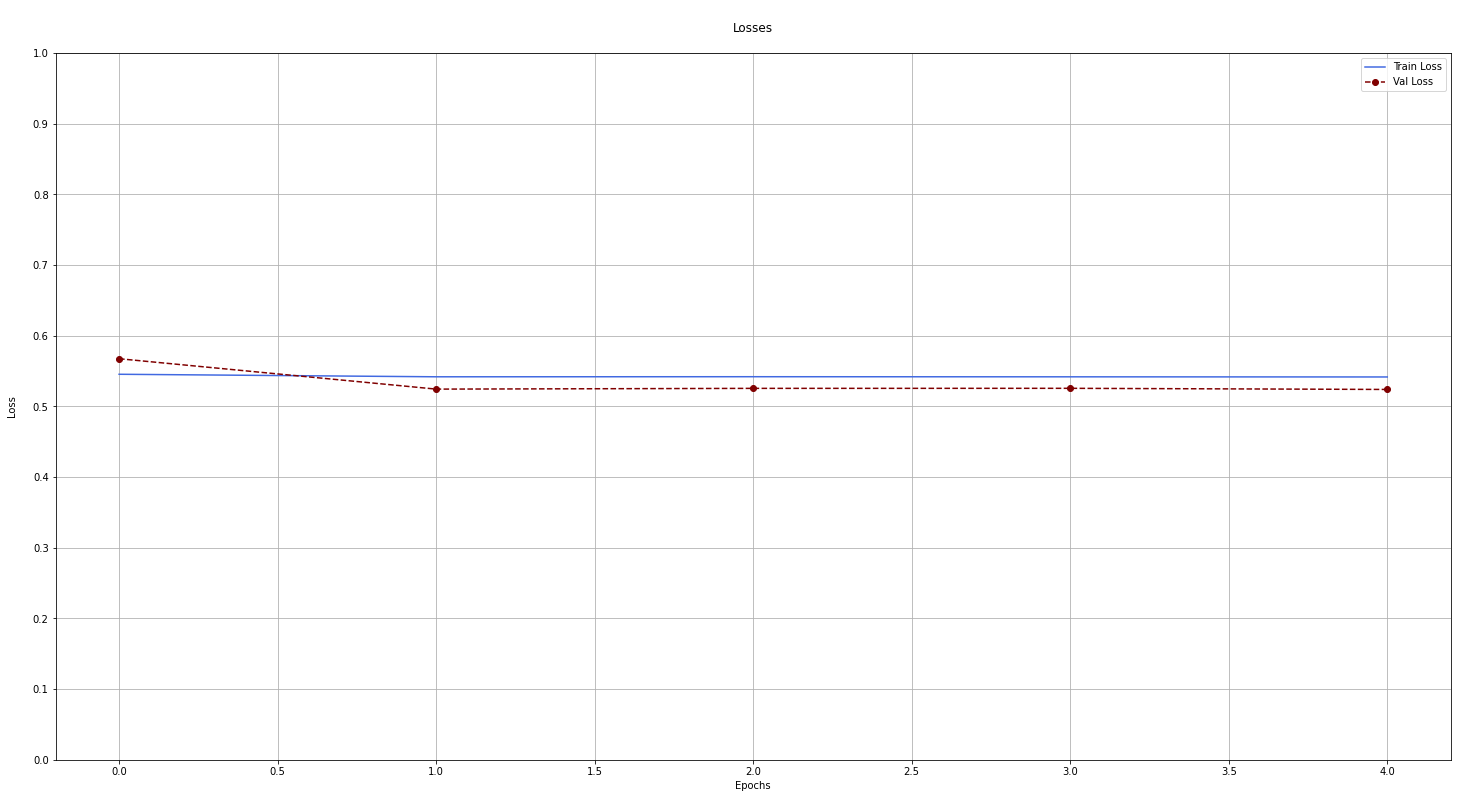

In [12]:
# plot the Training and Validation Losses
plot_metrics(metrics['train_losses'], metrics['val_losses'], 'Train Loss',
             'Val Loss', 'Loss\n', '\nLosses\n')

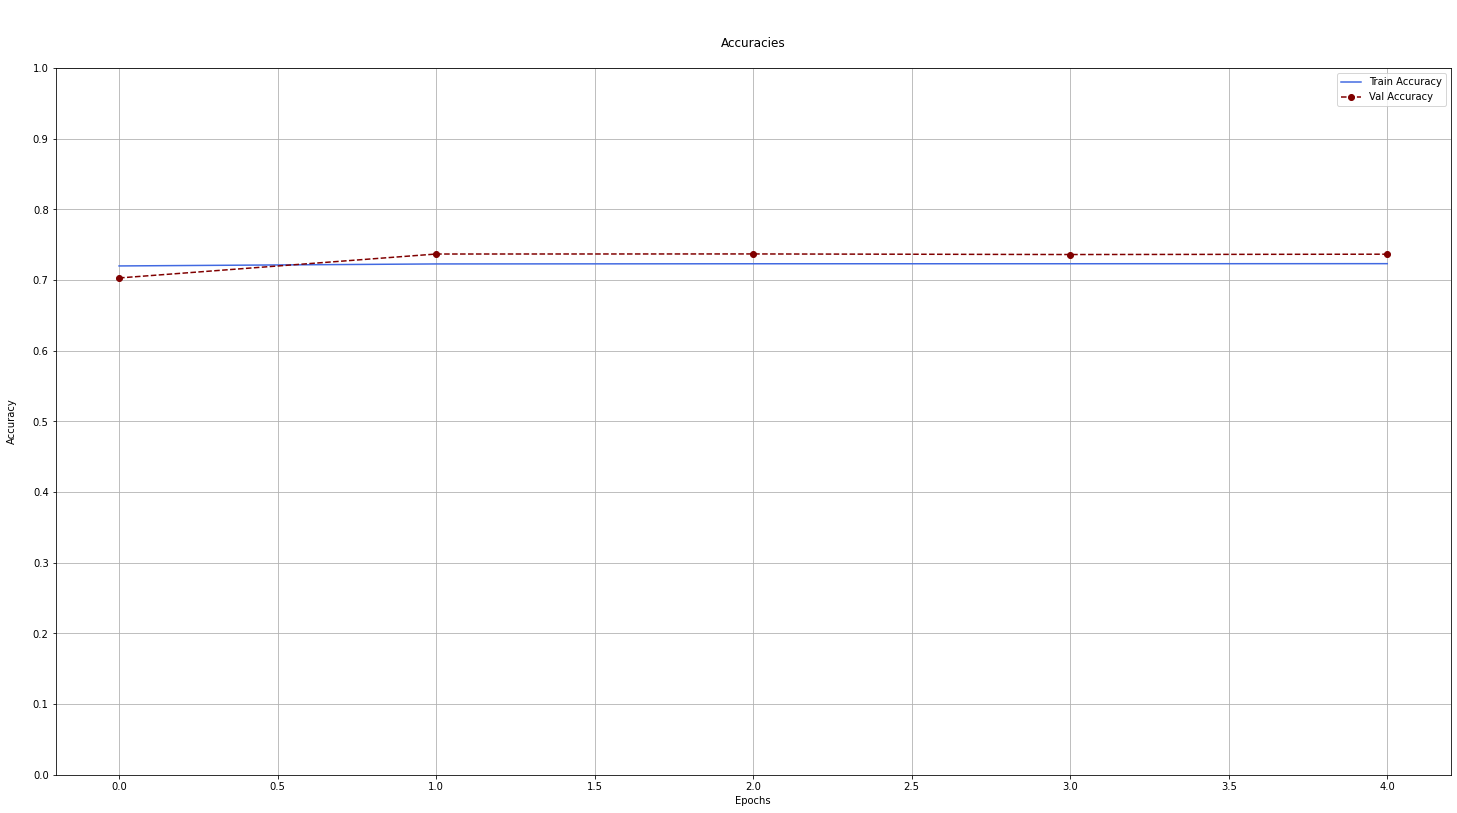

In [13]:
# plot the Training and Validation Accuracies
plot_metrics(metrics['train_accuracies'], metrics['val_accuracies'],
             'Train Accuracy', 'Val Accuracy', 'Accuracy\n', '\n\nAccuracies\n')

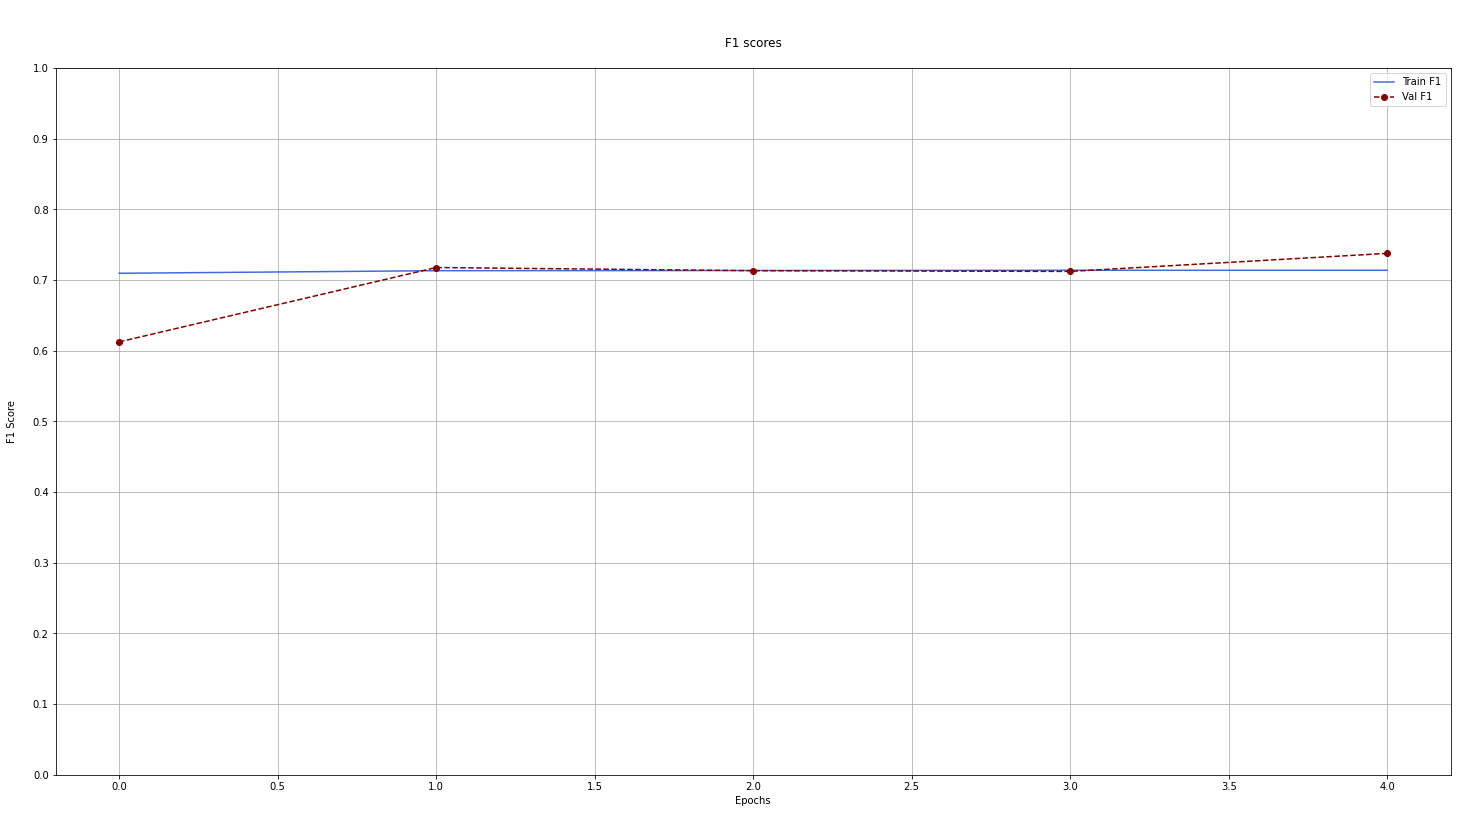

In [14]:
# plot the Training and Validation F1 scores
plot_metrics(metrics['train_f1'], metrics['val_f1'], 'Train F1', 'Val F1',
             'F1 Score\n', '\n\nF1 scores\n')

## Get the ground truths and the predictions for the whole Test Dataset

In [15]:
# function located in dataset.py
y_test, y_test_pred = get_truths_and_predictions(classifier, test_iterator)

In [16]:
y_test_pred

tensor([[0.8754],
        [0.0203],
        [0.5544],
        ...,
        [0.7070],
        [0.6944],
        [0.5547]], device='cuda:0')

## Classification report and Confusion Matrix

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

threshold = 0.5
predicted_test_labels = torch.where(y_test_pred > threshold, 1, 0)

print("Classification Report:")
print(f"{classification_report(y_test.cpu(), predicted_test_labels.cpu())}")
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test.cpu(), predicted_test_labels.cpu()))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.69      0.72     31906
         1.0       0.72      0.78      0.75     31972

    accuracy                           0.73     63878
   macro avg       0.74      0.73      0.73     63878
weighted avg       0.74      0.73      0.73     63878


Confusion Matrix:

[[22162  9744]
 [ 7191 24781]]


## Let's also plot the ROC Curve

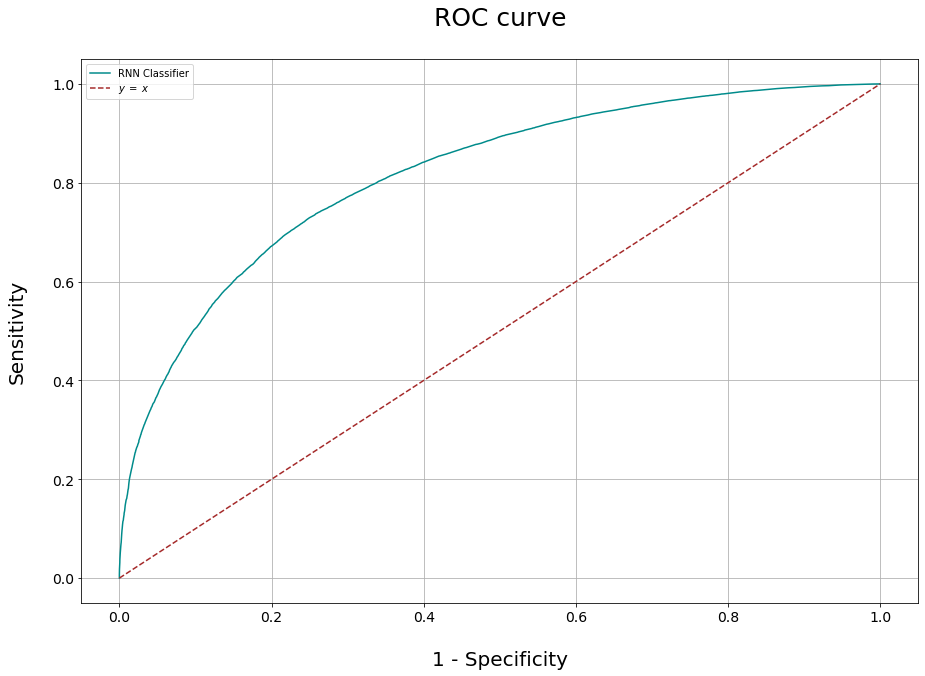

In [18]:
plot_roc_curve(y_test, y_test_pred)

# Custom Grid Search function

In [19]:
def grid_search(train_iterator, val_iterator, epochs, clip, TEXT, device,
                cell_types, hidden_dims, layers, learning_rates):
  """ Grid search to find the best model """
  for cell_type in cell_types:
    for hidden_dim in hidden_dims:
      for num_layers in layers:
        for lr in learning_rates:

          print('=' * 100)
          print('Config: cell type = {}, hidden_dim = {}, num_layers = {} and '
                'lr = {}'.format(cell_type, hidden_dim, num_layers, lr))
          print('=' * 100)

          config = {
              'cell_type': cell_type,
              'emb_dim': 100,
              'vocab_size': len(TEXT.vocab),
              'hidden_dim': hidden_dim,
              'num_layers': num_layers,
              'rnn_dropout': 0.15,
              'dropout_rate': 0.3,
              'bidirectional': True,
              'classes': 2
          }

          classifier = RNN(TEXT, config)
          classifier.to(device)

          optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
          criterion = nn.BCELoss().to(device)
          scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                 factor=0.5,
                                                                 patience=4,
                                                                 eps=1e-5,
                                                                 verbose=True)
          

          metrics = train(classifier, train_iterator, val_iterator, epochs,
                          optimizer, criterion, scheduler=scheduler, clip=clip,
                          unfreeze_on_epoch=0, verbose=True)
          
          train_loss = metrics['train_losses']
          val_loss = metrics['val_losses']
          plot_metrics(train_loss, val_loss, 'Train Loss',
                       'Val Loss', 'Loss\n', '\nLosses with config: cell type '
                       '= {}, hidden_dim = {}, num_layers = {} and lr = '
                       '{}\n'.format(cell_type, hidden_dim, num_layers, lr))

          train_acc = metrics['train_accuracies']
          val_acc = metrics['val_accuracies']
          plot_metrics(train_acc, val_acc, 'Train Accuracy',
                       'Val Accuracy', 'Accuracy\n', '\n\nAccuracies with '
                       'config: cell type = {}, hidden_dim = {}, num_layers = '
                       '{} and lr = {}\n'.format(cell_type, hidden_dim,
                                                 num_layers, lr))

          train_f1 = metrics['train_f1']
          val_f1 = metrics['val_f1']
          plot_metrics(train_f1, val_f1, 'Train F1', 'Val F1',
                       'F1 Score\n', '\n\nF1 scores with config: cell type = {}'
                       ', hidden_dim = {}, num_layers = {} and lr = '
                       '{}\n'.format(cell_type, hidden_dim, num_layers, lr))
          print('\n\n\n\n')

In [20]:
"""
cell_types = ['LSTM', 'GRU']
hidden_dims = [64, 128, 256, 512]
layers = [2, 3]
learning_rates = [0.01, 0.001]

grid_search(train_iterator, val_iterator, epochs, clip, TEXT, device,
            cell_types=cell_types,
            hidden_dims=hidden_dims,
            layers=layers,
            learning_rates=learning_rates)
"""

"\ncell_types = ['LSTM', 'GRU']\nhidden_dims = [64, 128, 256, 512]\nlayers = [2, 3]\nlearning_rates = [0.01, 0.001]\n\ngrid_search(train_iterator, val_iterator, epochs, clip, TEXT, device,\n            cell_types=cell_types,\n            hidden_dims=hidden_dims,\n            layers=layers,\n            learning_rates=learning_rates)\n"

## Predict your own sentences

In [21]:
def predict(classifier, sentence, TEXT, device, threshold=0.5):
  """ predict the sentiment of a given sentence """

  sentence = main_pipeline(sentence)
  split_sentence = sentence.split()
  words = len(split_sentence)
  
  tokenized_sentence = list(map(lambda word: TEXT.vocab.stoi.get(word, 0),
                                split_sentence))
  tokenized_sentence = torch.LongTensor(tokenized_sentence).reshape(-1, 1).to(device)
  length = torch.LongTensor([words]).to(device)

  with torch.no_grad():
    classifier.eval()
    value = classifier(tokenized_sentence, length)

  # print(value.item())
  if value >= threshold:
    return 1
  else:
    return 0

In [22]:
sentence = "ALFZ FYGE"
sentiment = predict(classifier, sentence, TEXT, device)

print("Sentiment predicted: ", sep='', end='')
if sentiment == 1:
  print("Positive")
else:
  print("Negative")

Sentiment predicted: Positive
